# Face Detection using a Pytorch CNN - Using LFW and AID Datasets

LFW Dataset - https://www.kaggle.com/jessicali9530/lfw-dataset

AID Dataset - https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import math
######
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
class NeetoCNN(nn.Module):

    def __init__(self, inchannels = 3):
        super(NeetoCNN, self).__init__()
        # 3 input image channel then 6 ch then 9 and finnally 12, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(inchannels, inchannels * 2, 7)
        self.conv2 = nn.Conv2d(inchannels * 2, inchannels * 3, 7)
        self.conv3 = nn.Conv2d(inchannels * 3, inchannels * 4, 7)
        self.conv4 = nn.Conv2d(inchannels * 4, inchannels * 5, 7)
        
        # an affine operation: y = Wx + b
        # Remember after a conv operation nout = (nin+2*npadding-nfilter)+1
        # in this example
        # conv1 = 250-7+1 = 244 => Maxpool => 122
        # conv2 = 122-7+1 = 122 => maxpool => 58
        # conv3 = 58-7+1 = 52 => maxpool => 26
        # conv4 = 26-7+1 = 20 => maxpool => 10
        self.fc1 = nn.Linear(inchannels * 5 * 10 * 10, 256)  # 10*10 from image dimension
        self.fc2 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(100, 25)
        self.fc4 = nn.Linear(25, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x.float())), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
myCNN = NeetoCNN()
print(myCNN)

NeetoCNN(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(6, 9, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(9, 12, kernel_size=(7, 7), stride=(1, 1))
  (conv4): Conv2d(12, 15, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=1500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=4, bias=True)
)


In [3]:
def str_converter(num, sz):
    num = str(num)
    while len(num) < sz:
        num = "0" + num
    return num

imagenes totales de personas 13240


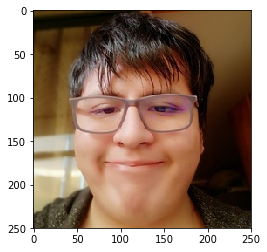

In [4]:
data_folder = "./Data/Data/"
face_folder = "lfw-deepfunneled/lfw-deepfunneled/"
name_ds = pd.read_csv(data_folder + "lfw/lfw_allnames.csv")
name_list = name_ds.values.tolist()
name = "Ricardo_Lazo_fd"
name_list.append([name, 7])
acum = 0
for i in name_list:
    acum += i[1]
print("imagenes totales de personas", acum)
im = Image.open(data_folder + "lfw/" + face_folder + name + "/" + name + "_0001.jpg")
imshow(np.asarray(im))

In [5]:
aid_aug_folder = "aid_aug/animals/"
animals = ["cats", "dogs", "panda"]
print("imagenes por animales: 1000 c/u")

imagenes por animales: 1000 c/u


In [6]:
Y = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])

In [7]:
# loss
loss_fn = nn.CrossEntropyLoss()
# learning rate
learning_rate = 1e-4
# optimizer
optimizer = torch.optim.Adam(myCNN.parameters(), lr=learning_rate)

In [8]:
for t in range(750):
    for i in animals:
        for j in range(1, 101):
            im = Image.open(data_folder + aid_aug_folder + i + "/" + i + "_" + str_converter(j, 5) + ".jpg")
            temp_np = np.reshape(np.array(im.convert("RGB")), (1,3,250,250))
            x = Variable(torch.from_numpy(temp_np)) 
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = myCNN(x) #4*1
            # Compute and print loss.
            if i == "cats":
                Y_case = np.take(Y,[1])
            elif i == "dogs":
                Y_case = np.take(Y,[2])
            else:
                Y_case = np.take(Y,[3])
            Y_case = torch.from_numpy(Y_case)
            loss = loss_fn(y_pred, Y_case)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    for i in name_list:
        for j in range(1, math.ceil(i[1] * 0.1)):
            im = Image.open(data_folder + "lfw/" + face_folder + i[0] + "/" + i[0] + "_" + str_converter(j, 4) + ".jpg")
            temp_np = np.reshape(np.array(im), (1,3,250,250))
            x = Variable(torch.from_numpy(temp_np)) 
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = myCNN(x) #4*1
            # Compute and print loss.
            loss = loss_fn(y_pred, torch.from_numpy(np.take(Y,[0])))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if t % 100 == 99:
        print ("it ==", t + 1)

it == 100
it == 200
it == 300
it == 400
it == 500
it == 600
it == 700


In [16]:
def pos_max(Y_pred):
    l = y_pred.tolist()
    l = l[0]
    #print(l)
    posmax = 0
    tempmax = -10000000
    for i in range(len(l)):
        if l[i] > tempmax:
            tempmax = l[i]
            posmax = i
    return posmax

In [17]:
conf_mat = np.zeros((4,4))
for i in animals:
    for j in range(101, 1001):
        im = Image.open(data_folder + aid_aug_folder + i + "/" + i + "_" + str_converter(j, 5) + ".jpg")
        temp_np = np.reshape(np.array(im.convert("RGB")), (1,3,250,250))
        x = Variable(torch.from_numpy(temp_np)) 
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = myCNN(x) #4*1
        # Compute and print loss.
        posmax = pos_max(y_pred)
        if i == "cats":
            conf_mat[1][posmax] += 1
        elif i == "dogs":
            conf_mat[2][posmax] += 1
        else:
            conf_mat[3][posmax] += 1

In [18]:
for i in name_list:
    for j in range(math.ceil(i[1] * 0.1), i[1] + 1):
        im = Image.open(data_folder + "lfw/" + face_folder + i[0] + "/" + i[0] + "_" + str_converter(j, 4) + ".jpg")
        temp_np = np.reshape(np.array(im), (1,3,250,250))
        x = Variable(torch.from_numpy(temp_np)) 
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = myCNN(x) #4*1
        posmax = pos_max(y_pred)
        conf_mat[0][posmax] +=1

In [19]:
print(conf_mat)

[[ 1614. 11273.     0.     0.]
 [  804.    96.     0.     0.]
 [  795.   105.     0.     0.]
 [  779.   121.     0.     0.]]
